# Example to use *pandas_datareader* and `to_excel()`

*pandas_datareader* パッケージを使って外部データを読み込み、pandas の `to_excel()` を使ってデータフレームをエクセルに書き出します。

- [pandas-datareader](https://pandas-datareader.readthedocs.io/en/latest/)
- [pandas.DataFrame.to_excel](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_excel.html)

## Setup

Python のモジュールを読み込み、世界銀行の API を使って、アメリカと日本の人口とGDPを取得します。indicator 文字列は世界銀行の API から取得しておきます。

In [1]:
import datetime
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader import wb

sns.set(style="darkgrid")

In [2]:
today = datetime.date.today()

df_gdp = wb.download(indicator='NY.GDP.PCAP.KD', country=['US', 'JP'], start=1960, end=today.year)
print(f'GDPのデータフレーム: サイズ={df_gdp.shape}, index名={df_gdp.index.names}')

df_population = wb.download(indicator='SP.POP.TOTL', country=['US', 'JP'], start=1960, end=today.year)
print(f'人口のデータフレーム: サイズ={df_population.shape}, index名={df_population.index.names}')

GDPのデータフレーム: サイズ=(120, 1), index名=['country', 'year']
人口のデータフレーム: サイズ=(120, 1), index名=['country', 'year']


## データの確認

In [3]:
df_gdp.head(3)

NY.GDP.PCAP.KD
country year                
Japan   2019             NaN
        2018    48919.798942
        2017    48438.834581

In [4]:
df_gdp.describe()

,NY.GDP.PCAP.KD
count,118.000000
mean,33947.959367
std,11896.295317
min,8607.657082
25%,23810.165035
50%,35668.018805
75%,44530.963740
max,54579.016837


GDP のデータフレームは以下の構成になっています。人口のデータフレームも同じような構成になっています。

* "country" と "year" のマルチインデックスになっている
* レコード数は120で、そのうちの118が有効な数値になっている
* 最小値は 8607.657082、最大値は 54579.016837 である
* データは最新のものから降順になっており、2019年の値は　`NaN` である。

## データを整形

このままでは使いにくいのでデータを整形します。

In [5]:
df1 = df_gdp.rename(columns={'NY.GDP.PCAP.KD': 'GDP_PERCAPITA'}).unstack(level=0)
df1.head(3)

GDP_PERCAPITA              
country         Japan United States
year                               
1960      8607.657082  17550.573164
1961      9396.221214  17659.056976
1962     10138.397014  18450.300931

In [6]:
df1['GDP_PERCAPITA'].describe()

country,Japan,United States
count,59.000000,59.000000
mean,32342.374478,35553.544256
std,12398.661342,11247.764860
min,8607.657082,17550.573164
25%,21952.050280,25607.748918
50%,36422.607009,35542.141105
75%,42734.385827,46634.054178
max,48919.798942,54579.016837


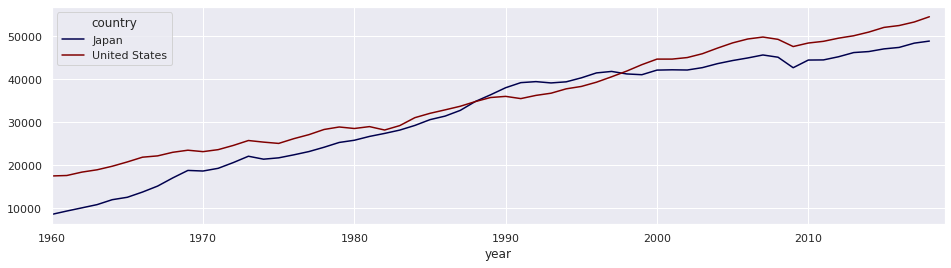

In [7]:
_ = df1['GDP_PERCAPITA'].plot(figsize=(16, 4), colormap='seismic')

人口のデータも同様に変換します。

In [8]:
df2 = df_population.rename(columns={'SP.POP.TOTL': 'POPULATION'}).unstack(level=0)
df2.head(3)

POPULATION              
country       Japan United States
year                             
1960     92500572.0   180671000.0
1961     94943000.0   183691000.0
1962     95832000.0   186538000.0

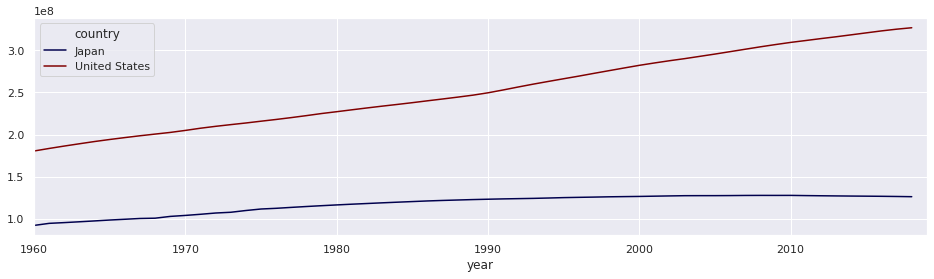

In [9]:
_ = df2['POPULATION'].plot(figsize=(16, 4), colormap='seismic')

５年の移動平均を計算してみると、アメリカは人口増加、日本は人口横ばいである傾向が少しハッキリします。

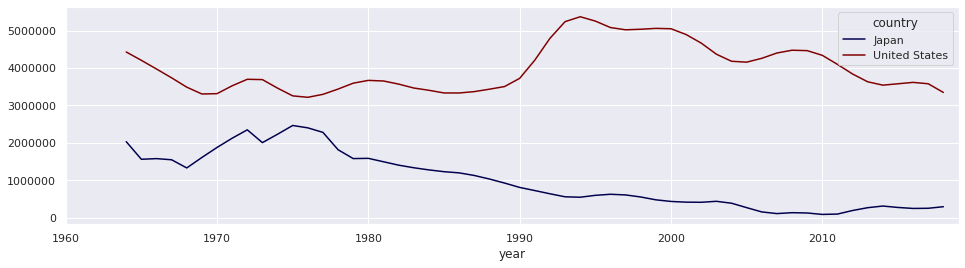

In [10]:
ax = df2['POPULATION'].rolling(window=5).std().plot(figsize=(16, 4), colormap='seismic')

## データの結合

２つのデータフレームを結合します。

In [11]:
df = pd.concat([df1, df2], axis=1)
df.head(3)

GDP_PERCAPITA                POPULATION              
country         Japan United States       Japan United States
year                                                         
1960      8607.657082  17550.573164  92500572.0   180671000.0
1961      9396.221214  17659.056976  94943000.0   183691000.0
1962     10138.397014  18450.300931  95832000.0   186538000.0

In [12]:
df.describe()

GDP_PERCAPITA                  POPULATION              
country         Japan United States         Japan United States
count       59.000000     59.000000  5.900000e+01  5.900000e+01
mean     32342.374478  35553.544256  1.180069e+08  2.525116e+08
std      12398.661342  11247.764860  1.104078e+07  4.421553e+07
min       8607.657082  17550.573164  9.250057e+07  1.806710e+08
25%      21952.050280  25607.748918  1.110510e+08  2.149135e+08
50%      36422.607009  35542.141105  1.231160e+08  2.468190e+08
75%      42734.385827  46634.054178  1.270678e+08  2.914566e+08
max      48919.798942  54579.016837  1.280700e+08  3.266875e+08

GDPを左軸、人口を右軸にしてグラフを描画してみます。

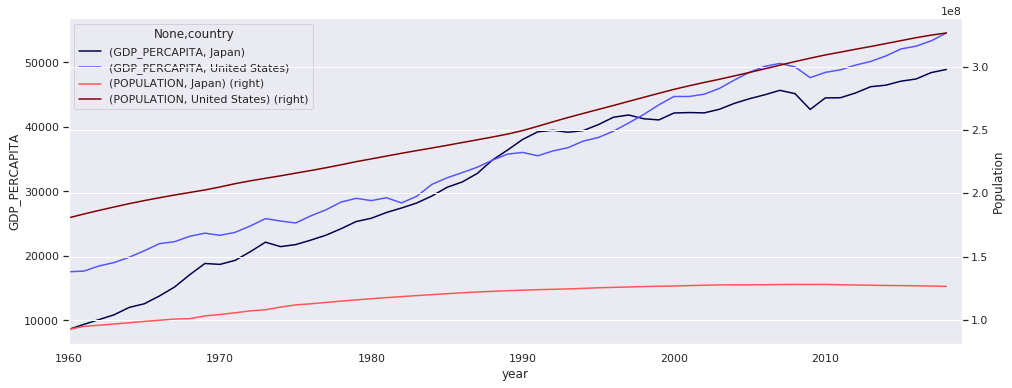

In [13]:
ax = df.plot(figsize=(16, 6), colormap='seismic',
             secondary_y=[('POPULATION', 'Japan'), ('POPULATION', 'United States')])
ax.set_ylabel('GDP_PERCAPITA')
_ = ax.right_ax.set_ylabel('Population')

単一のデータフレームで扱えるようになりました。

５年単位での分散を計算すると、日本の人口は1980年ごろから伸び悩み、GDPは1995年ごろから横ばいと言えます。
アメリカの場合は、1990年ごろに人口増加の波があり、2000年ごろにGDPの増加がピークを迎え、定期的に波があると言えます。

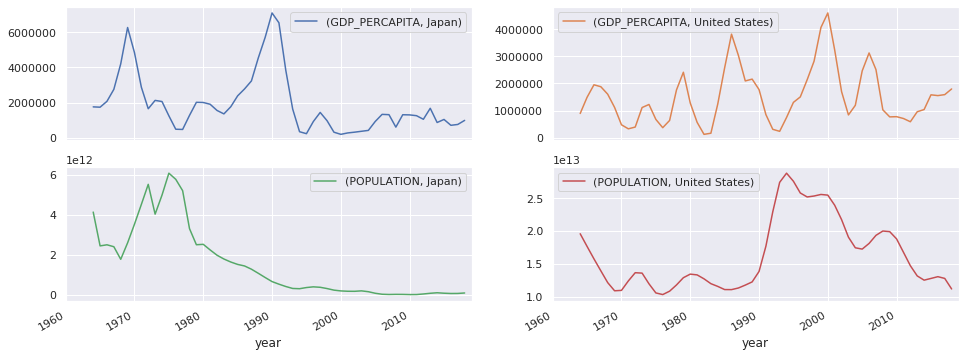

In [14]:
ax = df.rolling(window=5).var().plot(subplots=True, layout=(2, 2), figsize=(16, 6))

## データの出力

エクセルに出力します。データフレームのメソッドを呼び出しますが、エクセル書き出しモジュールがインストールされている必要があります。

In [15]:
outdir = Path.home()
outpath = outdir / 'sample.xlsx'

df.to_excel(outpath, sheet_name='Japan_US')

出来上がったデータをエクセルで開いてみてください。LibreOffice などでも構いません。